# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install meteostat

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
import glob
import time
import pickle
import numpy as np
import pandas as pd
from geopy.distance import distance
import datetime as datetime
from multiprocessing import Process, Manager
from sklearn.preprocessing import MinMaxScaler

import holidays
us_holidays = holidays.country_holidays('US')

# Read CSV

In [ ]:
raw_data = pd.DataFrame()

import glob
directory = '/content/drive/MyDrive/Thesis'
data_dir = directory + "/Data/Baywheels"


csv_files = glob.glob(f"{data_dir}/*.csv")

for csv in csv_files:
  raw_data = pd.concat([raw_data, pd.read_csv(csv)])

In [ ]:
raw_data = raw_data.dropna(subset=[
    'start_lat',
    'start_lng',
    'end_lat',
    'end_lng'])

raw_data['started_at'] = pd.to_datetime(raw_data['started_at'])
raw_data['ended_at'] = pd.to_datetime(raw_data['ended_at'])
raw_data['duration_sec'] = (raw_data['ended_at'] - raw_data['started_at'])/ pd.Timedelta(seconds=1)


# Finding Standard Stations

In [ ]:
start_stations = raw_data[["start_station_id",
                             'start_lat',
                             "start_lng"]]\
.sort_values(['start_lat', "start_lng"])\
.dropna().drop_duplicates(subset=['start_station_id'])\
.query("start_lat != 0").reset_index(drop=True).rename(
    columns={
        "start_station_id": "station_id",
        'start_lat': "station_latitude",
        "start_lng": "station_longitude"
  })

end_stations = raw_data[["end_station_id",
                           'end_lat',
                           "end_lng"]]\
.sort_values(['end_lat', "end_lng"])\
.dropna().drop_duplicates(subset=['end_station_id'])\
.query("end_lat != 0").reset_index(drop=True).rename(
    columns={"end_station_id": "station_id",
            'end_lat': "station_latitude",
            "end_lng": "station_longitude"
        })

In [ ]:
standard_stations = pd.concat([start_stations, end_stations]).sort_values(
    ['station_latitude', "station_longitude"]).drop_duplicates(subset=['station_id'])

# Approximate Station

In [ ]:
def calculate_geodesic_distance(df_stations, point):
    df = df_stations.copy()
    for idx, i, j  in zip(df.index, df.station_latitude, df.station_longitude):
        df.loc[idx, 'distance'] = distance(point, (i,j)).m
        if int(df.loc[idx, 'distance']) == 0:

            return df.loc[idx, "station_id"], df.loc[idx, 'distance']
    df = df.sort_values("distance")
    return df.iloc[0]["station_id"], df.iloc[0]["distance"]

In [ ]:
def get_approximate_stations_locations(df_missing_stations, start_stations, col="start"):

    for idx, i, j in zip(df_missing_stations.index,
                         df_missing_stations[f'{col}_lat'],
                         df_missing_stations[f'{col}_lng']):

        approx_station, approx_distance = calculate_geodesic_distance(start_stations,
                            (i, j))
        df_missing_stations.loc[idx,f"{col}_approx"] = approx_station
        df_missing_stations.loc[idx,f"{col}_approx_distance"] = approx_distance


    return df_missing_stations

In [ ]:
missing_stations = (raw_data['start_station_id'].isna()) |\
                      (raw_data['end_station_id'].isna())

df_missing_stations = raw_data[missing_stations].copy()

df_existing_stations = raw_data[~(missing_stations)].copy()

df_missing_start_stations_no_duplicates = df_missing_stations.drop_duplicates(
                                        subset=['start_lat', 'start_lng']).copy()\
                                            .reset_index(drop=True)
df_missing_start_stations_no_duplicates = df_missing_start_stations_no_duplicates[
                                            df_missing_start_stations_no_duplicates['start_station_id'].isna()].copy()\
                                            .reset_index(drop=True)

df_missing_end_stations_no_duplicates = df_missing_stations.drop_duplicates(
                                        subset=['end_lat', 'end_lng']).copy()\
                                            .reset_index(drop=True)
df_missing_end_stations_no_duplicates = df_missing_end_stations_no_duplicates[
                                            df_missing_end_stations_no_duplicates['end_station_id'].isna()].copy()\
                                                .reset_index(drop=True)

In [ ]:
approximate_start_stations_df = get_approximate_stations_locations(df_missing_start_stations_no_duplicates,
                                   standard_stations.reset_index(drop=True).copy(),
                                            col ="start")

In [ ]:
approximate_end_stations_df = get_approximate_stations_locations(df_missing_end_stations_no_duplicates,
                                   standard_stations.reset_index(drop=True).copy(),
                                         col ="end")

In [ ]:
df_missing_stations = df_missing_stations.merge(
    approximate_start_stations_df[["start_approx",
                             'start_lat',
                             'start_lng',
                             'start_approx_distance']],
    on=['start_lat',
        'start_lng'], how="left")

In [ ]:
df_missing_stations = df_missing_stations.merge(
    approximate_end_stations_df[["end_approx",
                             'end_lat',
                             'end_lng',
                             'end_approx_distance']],
    on=['end_lat',
        'end_lng'], how="left")

In [ ]:
index = df_missing_stations['start_approx_distance'] < 500
df_missing_stations.loc[index, 'start_station_id'] = df_missing_stations.loc[index, 'start_approx']

index = df_missing_stations['end_approx_distance'] < 500
df_missing_stations.loc[index, 'end_station_id'] = df_missing_stations.loc[index, 'end_approx']

In [ ]:
df_completed_stations = df_missing_stations.dropna(subset=['start_station_id', 'end_station_id'])

In [ ]:
df_existing_stations = df_existing_stations.drop(columns=['start_station_name', 'end_station_name'])
df_completed_stations = df_completed_stations.drop(columns=['start_station_name', 'end_station_name'])
df = pd.concat([df_completed_stations, df_existing_stations]).copy()
#df.to_csv("baywheels_confirmed_stations.csv")

In [ ]:
df.shape

(5612111, 16)

In [ ]:
df = df[
    (df['end_lat'] != 0) & (df['start_lat'] != 0) & (df['end_lng'] != 0) & (df['start_lng'] != 0) &\
    (~df['end_lat'].isna()) & (~df['start_lat'].isna()) & (~df['end_lng'].isna()) & (~df['start_lng'].isna())
]

In [ ]:
df.shape

(5612103, 16)

In [ ]:
raw_data.shape

(5815902, 14)

In [ ]:
df.shape

(5612103, 16)

In [ ]:
del raw_data

# Dropping Trips < X minutes duration, where start = end

X = 4

In [ ]:
minutes = 4
minutes_not_same = 2

df_same_station = df[(df['start_station_id'] == df['end_station_id']) &
                     (df['duration_sec'] > minutes*60)]


df_no_same_station = df[(df['start_station_id'] != df['end_station_id']) &
                     (df['duration_sec'] > minutes_not_same*60)]

df_final = pd.concat([df_no_same_station, df_same_station]).reset_index(drop=True).drop_duplicates()

In [ ]:
m = df[~(((df['start_station_id'] == df['end_station_id']) & (df['duration_sec'] > minutes*60)) |\
     ((df['start_station_id'] != df['end_station_id']) & (df['duration_sec'] > minutes_not_same*60)))]

In [ ]:
l = m.apply(lambda x: distance((x['start_lat'], x['start_lng']), (x['end_lat'], x['end_lng'])).m, axis=1)

In [ ]:
l.shape

(326334,)

In [ ]:
l.mean()

287.1984394809223

In [ ]:
l.median()

11.731584523740471

In [ ]:
l[l < 100].shape[0]/l.shape[0]

0.6275196577739371

In [ ]:
df.shape

(5612103, 16)

In [ ]:
df_no_same_station.shape

(5144667, 16)

In [ ]:
df_same_station.shape

(141102, 16)

In [ ]:
df_final.shape

(5285769, 16)

In [ ]:
del m

In [ ]:
del df_no_same_station
del df_same_station

# Change Types

In [ ]:
df = df_final.dropna(subset=['start_station_id', 'end_station_id']).drop(['rideable_type', 'member_casual', 'start_approx',	'start_approx_distance',	'end_approx',	'end_approx_distance'], axis=1)
#df['start_station_id'] = pd.to_numeric(df['start_station_id'])
#df['end_station_id'] = pd.to_numeric(df['end_station_id'])
df['ended_at'] = pd.to_datetime(df['ended_at'])
df['started_at'] = pd.to_datetime(df['started_at'])

df.dtypes

,0
ride_id,object
started_at,datetime64[ns]
ended_at,datetime64[ns]
start_station_id,object
end_station_id,object
start_lat,float64
start_lng,float64
end_lat,float64
end_lng,float64
duration_sec,float64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5285769 entries, 0 to 5285768
Data columns (total 10 columns):
 #   Column            Dtype         
---  ------            -----         
 0   ride_id           object        
 1   started_at        datetime64[ns]
 2   ended_at          datetime64[ns]
 3   start_station_id  object        
 4   end_station_id    object        
 5   start_lat         float64       
 6   start_lng         float64       
 7   end_lat           float64       
 8   end_lng           float64       
 9   duration_sec      float64       
dtypes: datetime64[ns](2), float64(5), object(3)
memory usage: 403.3+ MB


# Add Weather data

In [ ]:
import geopandas as gp
import datetime as datetime
import plotly.express as px
import plotly.graph_objects as go
from sklearn.cluster import DBSCAN
from meteostat import Point, Hourly
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import haversine_distances


In [ ]:
points_in_radians = standard_stations[['station_latitude','station_longitude']].apply(np.radians).values
distances_in_km = haversine_distances(points_in_radians) * 6371

In [ ]:
distance_matrix = distances_in_km

clustering_areas = DBSCAN(eps=0.1, min_samples=20)
clustering_stations = DBSCAN(eps=0.0041, min_samples=1)
scaler = MinMaxScaler()
df_temp = standard_stations.copy()
df_temp[['station_latitude', 'station_longitude']] = \
                            scaler.fit_transform(df_temp[['station_latitude', 'station_longitude']])
clusters_areas = clustering_areas.fit_predict(df_temp[['station_latitude', 'station_longitude']])

clusters_stations = clustering_stations.fit_predict(df_temp[['station_latitude', 'station_longitude']])

In [ ]:
del df_temp

In [ ]:
standard_stations['clusters'] = clusters_areas
standard_stations['cluster_stations'] = clusters_stations

centroids = standard_stations.groupby("clusters")[['station_latitude', 'station_longitude']].mean()
centroids = centroids.reset_index().rename(columns={
    "station_latitude": "station_latitude_centroid",
    "station_longitude": "station_longitude_centroid",
})

centroid_stations = standard_stations.groupby("cluster_stations")[['station_latitude', 'station_longitude']].mean()
centroid_stations = centroid_stations.reset_index().rename(columns={
    "station_latitude": "station_latitude_centroid_stations",
    "station_longitude": "station_longitude_centroid_stations",
})

In [ ]:
standard_stations = standard_stations.merge(centroid_stations, on=['cluster_stations'], how="left")

In [ ]:
standard_stations

,station_id,station_latitude,station_longitude,clusters,cluster_stations,station_latitude_centroid_stations,station_longitude_centroid_stations
0,SJ-M11-1,37.306075,-121.857710,0,0,37.306075,-121.857710
1,SJ-Q4,37.308889,-121.899986,0,1,37.308889,-121.899986
2,SJ-Q5,37.311145,-121.896271,0,2,37.311145,-121.896271
3,SJ-P6,37.315002,-121.897765,0,3,37.315002,-121.897765
4,SJ-O4,37.316623,-121.909885,0,4,37.316623,-121.909885
...,...,...,...,...,...,...,...
589,BK-C5,37.873558,-122.283093,2,369,37.873558,-122.283093
590,BK-C7,37.873676,-122.268487,2,368,37.873016,-122.267467
591,BK-C9,37.875321,-122.260155,2,370,37.875321,-122.260155
592,BK-B7,37.876573,-122.269528,2,371,37.876573,-122.269528


In [ ]:
cluster_weather_dict = {}
station_weather_dict = {}

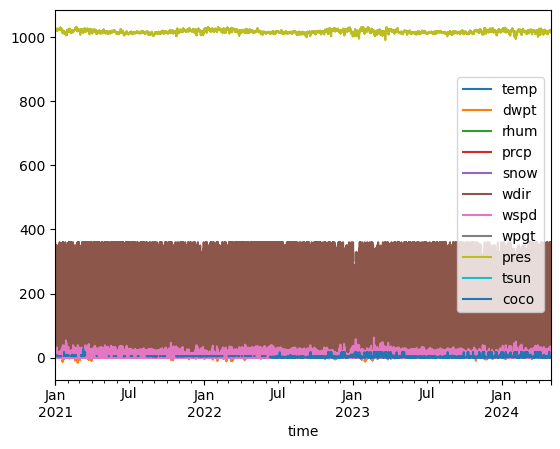

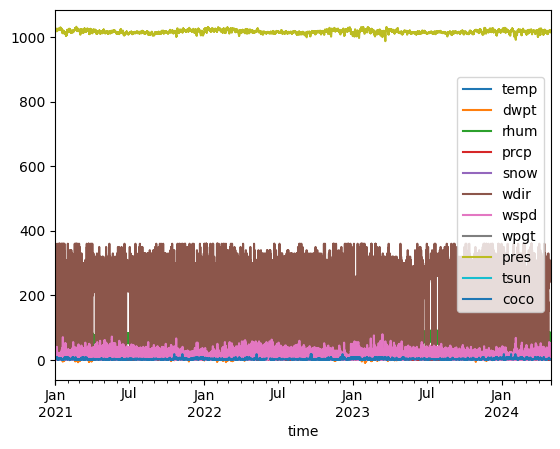

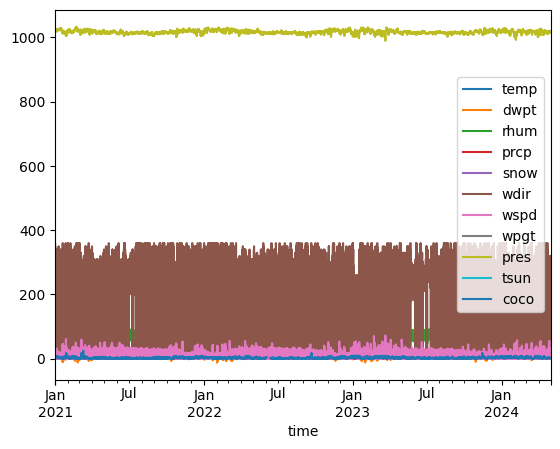

In [ ]:
start = datetime.datetime(2020, 12, 31)
end = datetime.datetime(2024, 5, 1)

for ii in centroids.index:


    # Create Point for Vancouver, BC
    location = Point(centroids.loc[ii]['station_latitude_centroid'],
                     centroids.loc[ii]['station_longitude_centroid'])
    # Get daily data for 2018
    data = Hourly(location, start, end)
    data = data.fetch()
    cluster_weather_dict[centroids.loc[ii]['clusters']] = data
    # Plot line chart including average, minimum and maximum temperature
    data.plot(y=['temp', 'dwpt', 'rhum', 'prcp', 'snow',
                 'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'coco'])


In [ ]:
weather_data = pd.DataFrame()

for ii in cluster_weather_dict:
    cluster_weather_dict[ii] = cluster_weather_dict[ii].interpolate()
    cluster_weather_dict[ii]['centroid'] = ii

    weather_data = pd.concat([weather_data, cluster_weather_dict[ii]])

In [ ]:
centroid_stations

,cluster_stations,station_latitude_centroid_stations,station_longitude_centroid_stations
0,0,37.306075,-121.857710
1,1,37.308889,-121.899986
2,2,37.311145,-121.896271
3,3,37.315002,-121.897765
4,4,37.316623,-121.909885
...,...,...,...
368,368,37.873016,-122.267467
369,369,37.873558,-122.283093
370,370,37.875321,-122.260155
371,371,37.876573,-122.269528


In [ ]:
fig = px.scatter_mapbox(standard_stations, lat='station_latitude', lon='station_longitude',
                        color = "clusters",
                        mapbox_style="open-street-map",
                        hover_name="station_id",
                       )

fig.add_trace(go.Scattermapbox(
        lat=centroids['station_latitude_centroid'],
        lon=centroids['station_longitude_centroid'],
        mode='markers',
        hoverinfo='text',
        name="Cluster Centroids",
        marker=go.scattermapbox.Marker(
            size=15,
            color='rgb(0, 0, 0)',
            opacity=0.7
        ),
    ))

fig.update_geos(fitbounds="locations")
fig.show()

In [ ]:
fig = px.scatter_mapbox(standard_stations, lat='station_latitude', lon='station_longitude',
                        color = "cluster_stations",
                        mapbox_style="open-street-map",
                        hover_name="station_id",
                       )

fig.add_trace(go.Scattermapbox(
        lat=centroid_stations['station_latitude_centroid_stations'],
        lon=centroid_stations['station_longitude_centroid_stations'],
        mode='markers',
        hoverinfo='text',
        name="Cluster Centroids",
        marker=go.scattermapbox.Marker(
            size=15,
            color='rgb(0, 0, 0)',
            opacity=0.7
        ),
    ))

fig.update_geos(fitbounds="locations")
fig.show()

# Final DF

In [ ]:
def create_datetime_features(input_df, column_name):

    input_df[column_name+'_hour'] = input_df[column_name].dt.hour
    input_df[column_name+'_minute'] = input_df[column_name].dt.minute
    input_df[column_name+'_quarter'] = input_df[column_name].dt.quarter
    input_df[column_name+'_month'] = input_df[column_name].dt.month
    input_df[column_name+'_year'] = input_df[column_name].dt.year
    input_df[column_name+'_week'] = input_df[column_name].dt.isocalendar().week
    input_df[column_name+'_day'] = input_df[column_name].dt.day
    input_df[column_name+'_dayofweek'] = input_df[column_name].dt.dayofweek

    return input_df

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5285769 entries, 0 to 5285768
Data columns (total 10 columns):
 #   Column            Dtype         
---  ------            -----         
 0   ride_id           object        
 1   started_at        datetime64[ns]
 2   ended_at          datetime64[ns]
 3   start_station_id  object        
 4   end_station_id    object        
 5   start_lat         float64       
 6   start_lng         float64       
 7   end_lat           float64       
 8   end_lng           float64       
 9   duration_sec      float64       
dtypes: datetime64[ns](2), float64(5), object(3)
memory usage: 403.3+ MB


In [ ]:
df = df.merge(
    standard_stations.rename(columns={
        "station_id": 'start_station_id'
    }), on= 'start_station_id', how='left'
)

df['start_lat'] = df['station_latitude']
df['start_lng'] = df['station_longitude']
df['start_station_cluster'] = df['cluster_stations']

df = df.drop(columns=['station_latitude', 'station_longitude', 'clusters', 'cluster_stations'])
df = df.merge(
    standard_stations.rename(columns={
        "station_id": 'end_station_id'
    }), on= 'end_station_id', how='left'
)

df['end_lat'] = df['station_latitude']
df['end_lng'] = df['station_longitude']
df['end_station_cluster'] = df['cluster_stations']
df = df.drop(columns=['station_latitude', 'station_longitude', 'clusters', 'cluster_stations'])

df = df.rename(columns={
    "station_latitude_centroid_stations_x": "start_station_latitude_centroid_stations",
    "station_longitude_centroid_stations_x": "start_station_longitude_centroid_stations",
    "station_latitude_centroid_stations_y": "end_station_latitude_centroid_stations",
    "station_longitude_centroid_stations_y": "end_station_longitude_centroid_stations"
})

In [ ]:
df.shape#['cluster_stations'].value_counts()

(5285769, 16)

In [ ]:
df = create_datetime_features(df, 'started_at')
df = create_datetime_features(df, 'ended_at')

In [ ]:
data_dir = directory + "/Data/"

le = LabelEncoder()

le.fit(standard_stations['station_id'])

with open(f'{data_dir}/station_encoder.pkl', 'wb') as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)

standard_stations.to_csv(f"{data_dir}/standard_stations.csv")

In [ ]:
from sklearn.utils.extmath import cartesian
from geopy.distance import geodesic

# Get all possible start locations and their geo info
subset = ["start_lng", "start_lat", "start_station_id"]
all_starts = df.drop_duplicates(subset="start_station_id", keep="first")[subset]
# Get all possible end locations and their geo info
subset = ["end_lng", "end_lat", "end_station_id"]
all_ends = df.drop_duplicates(subset="end_station_id", keep="first")[subset]
# Combine all combinations in one dataframe
distance_matrix = all_ends.merge(all_starts, how="cross")
distance_matrix["distance"] = distance_matrix.apply(lambda x: geodesic((x["start_lat"], x["start_lng"]),
                                                          (x["end_lat"], x["end_lng"])).meters, axis=1)
distance_matrix.head()

distance_matrix.to_csv(f"{data_dir}/distance_matrix.csv")

In [ ]:
from sklearn.utils.extmath import cartesian
from geopy.distance import geodesic


# Get all possible start locations and their geo info
subset = ["start_station_longitude_centroid_stations", "start_station_latitude_centroid_stations", "start_station_cluster"]
all_starts = df.drop_duplicates(subset="start_station_id", keep="first")[subset]
# Get all possible end locations and their geo info
subset = ["end_station_longitude_centroid_stations", "end_station_latitude_centroid_stations", "end_station_cluster"]
all_ends = df.drop_duplicates(subset="end_station_id", keep="first")[subset]
# Combine all combinations in one dataframe
distance_matrix = all_ends.merge(all_starts, how="cross")
distance_matrix["distance"] = distance_matrix.apply(lambda x: geodesic((x["start_station_latitude_centroid_stations"], x["start_station_longitude_centroid_stations"]),
                                                          (x["end_station_latitude_centroid_stations"], x["end_station_longitude_centroid_stations"])).meters, axis=1)
wanted_clusters_stations = standard_stations[standard_stations['clusters'] == 1]['cluster_stations']

distance_matrix = distance_matrix[
    distance_matrix['start_station_cluster'].isin(wanted_clusters_stations) &\
    distance_matrix['end_station_cluster'].isin(wanted_clusters_stations)
]

distance_matrix.to_csv(f"{data_dir}/distance_matrix_centroids.csv")

In [ ]:
weather_data_time = weather_data.reset_index().rename(columns={
    "time": "started_at_hourly"
})

In [ ]:
column_name='started_at'
conversion_dict_hourly = dict(year= df[f'{column_name}_year'],
                              month=df[f'{column_name}_month'],
                              day=  df[f'{column_name}_day'],
                              hour= df[f'{column_name}_hour']
                              )

df[f'{column_name}_hourly'] = pd.to_datetime(conversion_dict_hourly)

In [ ]:
df[f'{column_name}_hourly']

,started_at_hourly
0,2022-01-27 08:00:00
1,2022-01-27 07:00:00
2,2022-01-02 02:00:00
3,2022-01-24 23:00:00
4,2022-01-23 18:00:00
...,...
5285764,2024-03-16 10:00:00
5285765,2024-03-16 16:00:00
5285766,2024-03-17 17:00:00
5285767,2024-03-15 21:00:00


In [ ]:
# df = df.merge(weather_data_time[['temp', 'dwpt', "rhum", "prcp", "wdir", "wspd", "pres", "coco", "centroid", 'started_at_hourly']].rename(columns={
#     "centroid":"start_station_cluster"
# }), on=['start_station_cluster', "started_at_hourly"])

In [ ]:
weather_data_time.to_csv(f"{data_dir}/weather_data.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5285769 entries, 0 to 5285768
Data columns (total 33 columns):
 #   Column                                     Dtype         
---  ------                                     -----         
 0   ride_id                                    object        
 1   started_at                                 datetime64[ns]
 2   ended_at                                   datetime64[ns]
 3   start_station_id                           object        
 4   end_station_id                             object        
 5   start_lat                                  float64       
 6   start_lng                                  float64       
 7   end_lat                                    float64       
 8   end_lng                                    float64       
 9   duration_sec                               float64       
 10  start_station_latitude_centroid_stations   float64       
 11  start_station_longitude_centroid_stations  float64       
 12  

In [ ]:
standard_stations

,station_id,station_latitude,station_longitude,clusters,cluster_stations,station_latitude_centroid_stations,station_longitude_centroid_stations
0,SJ-M11-1,37.306075,-121.857710,0,0,37.306075,-121.857710
1,SJ-Q4,37.308889,-121.899986,0,1,37.308889,-121.899986
2,SJ-Q5,37.311145,-121.896271,0,2,37.311145,-121.896271
3,SJ-P6,37.315002,-121.897765,0,3,37.315002,-121.897765
4,SJ-O4,37.316623,-121.909885,0,4,37.316623,-121.909885
...,...,...,...,...,...,...,...
589,BK-C5,37.873558,-122.283093,2,369,37.873558,-122.283093
590,BK-C7,37.873676,-122.268487,2,368,37.873016,-122.267467
591,BK-C9,37.875321,-122.260155,2,370,37.875321,-122.260155
592,BK-B7,37.876573,-122.269528,2,371,37.876573,-122.269528


In [ ]:
points_in_radians = standard_stations[['station_latitude_centroid_stations','station_longitude_centroid_stations']].apply(np.radians).values
distances_in_km = haversine_distances(points_in_radians) * 6371

In [ ]:
distances_in_km

array([[ 0.        ,  3.75213825,  3.45669797, ..., 72.55251906,
        73.08031572, 73.44242791],
       [ 3.75213825,  0.        ,  0.41337579, ..., 70.52677551,
        71.02572656, 71.39537477],
       [ 3.45669797,  0.41337579,  0.        , ..., 70.45101476,
        70.9538024 , 71.32249974],
       ...,
       [72.55251906, 70.52677551, 70.45101476, ...,  0.        ,
         0.83432699,  1.00512798],
       [73.08031572, 71.02572656, 70.9538024 , ...,  0.83432699,
         0.        ,  0.40489542],
       [73.44242791, 71.39537477, 71.32249974, ...,  1.00512798,
         0.40489542,  0.        ]])

In [ ]:
df.to_csv(f"{data_dir}/df_final_dataframe.csv")

In [ ]:
df

,ride_id,started_at,ended_at,start_station_id,end_station_id,start_lat,start_lng,end_lat,end_lng,duration_sec,...,started_at_dayofweek,ended_at_hour,ended_at_minute,ended_at_quarter,ended_at_month,ended_at_year,ended_at_week,ended_at_day,ended_at_dayofweek,started_at_hourly
0,884A7D9D6368A877,2022-01-27 08:29:53,2022-01-27 08:38:27,SF-E22,SF-A19,37.781024,-122.433949,37.804075,-122.439119,514.0,...,3,8,38,1,1,2022,4,27,3,2022-01-27 08:00:00
1,A0019F8B46228B07,2022-01-27 07:22:45,2022-01-27 07:25:37,SF-N21,SF-I21,37.757048,-122.433663,37.760514,-122.419238,172.0,...,3,7,25,1,1,2022,4,27,3,2022-01-27 07:00:00
2,BFD87520609D43EF,2022-01-02 02:31:41,2022-01-02 02:37:04,SF-E22,SF-E23,37.781024,-122.433949,37.787808,-122.419579,323.0,...,6,2,37,1,1,2022,52,2,6,2022-01-02 02:00:00
3,0EFAFF41D9D92A65,2022-01-24 23:26:47,2022-01-24 23:40:48,SF-N21,OutsideTempStation,37.757048,-122.433663,37.770435,-122.450957,841.0,...,0,23,40,1,1,2022,4,24,0,2022-01-24 23:00:00
4,B88F46EF17A71352,2022-01-23 18:15:48,2022-01-23 18:19:13,SF-N21,SF-I21,37.757048,-122.433663,37.760514,-122.419238,205.0,...,6,18,19,1,1,2022,3,23,6,2022-01-23 18:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5285764,34A0DAC97B40FB48,2024-03-16 10:22:50,2024-03-16 12:17:55,SF-A24-2,SF-A24-2,37.798942,-122.407751,37.798942,-122.407751,6905.0,...,5,12,17,1,3,2024,11,16,5,2024-03-16 10:00:00
5285765,A8350268241CC52A,2024-03-16 16:49:51,2024-03-17 10:22:40,OK-G5,OK-G5,37.824893,-122.260437,37.824893,-122.260437,63169.0,...,5,10,22,1,3,2024,11,17,6,2024-03-16 16:00:00
5285766,C4E592142CDCC232,2024-03-17 17:30:47,2024-03-17 17:35:36,SF-A24-2,SF-A24-2,37.798942,-122.407751,37.798942,-122.407751,289.0,...,6,17,35,1,3,2024,11,17,6,2024-03-17 17:00:00
5285767,90087D7FBECB07A7,2024-03-15 21:19:58,2024-03-15 21:35:57,SF-F28-2,SF-F28-2,37.754592,-122.389876,37.754592,-122.389876,959.0,...,4,21,35,1,3,2024,11,15,4,2024-03-15 21:00:00


# Aggregates

In [ ]:
df['start_station_cluster']

,start_station_cluster
0,228
1,150
2,228
3,150
4,150
...,...
5285764,265
5285765,305
5285766,265
5285767,147


In [ ]:
import numpy as np
# Find out how many outgoing bikers we have
outgoing_trips = df.groupby("start_station_cluster")["ride_id"].count()
incoming_trips = df.groupby("end_station_cluster")["ride_id"].count()

# Normalize features between 0 and 1
outgoing_trips = (outgoing_trips - np.min(outgoing_trips)) / (np.max(outgoing_trips) - np.min(outgoing_trips))
incoming_trips = (incoming_trips - np.min(incoming_trips)) / (np.max(incoming_trips) - np.min(incoming_trips))

outgoing_trips = outgoing_trips.reindex(outgoing_trips.index.union(incoming_trips.index), fill_value=0).sort_index()
incoming_trips = incoming_trips.reindex(outgoing_trips.index, fill_value=0).sort_index()

# Build node features
node_features = np.stack([outgoing_trips, incoming_trips]).transpose()
print("Full shape: ", node_features.shape)
node_features[:10] # [num_nodes x num_features]

Full shape:  (373, 2)


array([[0.00713176, 0.00693137],
       [0.00231848, 0.00287274],
       [0.00085536, 0.00089626],
       [0.00066028, 0.00063012],
       [0.00160193, 0.00163206],
       [0.0014181 , 0.00145203],
       [0.00165445, 0.00183558],
       [0.00350023, 0.00443436],
       [0.00142935, 0.00108804],
       [0.00299001, 0.00364768]])

In [ ]:
agg_demand = df.groupby(
    by=["start_station_cluster", "started_at_year",
        "started_at_month", "started_at_day",
        "started_at_hour"]).agg({
    "ride_id": "count",
    "duration_sec": "mean",
})
agg_return_bikes = df.groupby(
    by=[
        "end_station_cluster", "ended_at_year",
        "ended_at_month", "ended_at_day",
        "ended_at_hour"]).agg({
    "ride_id": "count",
    "duration_sec": "mean",
})

In [ ]:
agg_demand

ride_id  \
start_station_cluster started_at_year started_at_month started_at_day started_at_hour            
0                     2022            1                1              2                      1   
                                                       4              15                     1   
                                                       7              12                     1   
                                                                      19                     1   
                                                       9              12                     1   
...                                                                                        ...   
372                   2024            3                30             12                     2   
                                                       31             10                     1   
                                                                      12                     1   
                                                                      17                     2   
                                                                      18                     1   

                                                                                       duration_sec  
start_station_cluster started_at_year started_at_month started_at_day started_at_hour                
0                     2022            1                1              2                       851.0  
                                                       4              15                      162.0  
                                                       7              12                      780.0  
                                                                      19                      501.0  
                                                       9              12                      426.0  
...                                                                                             ...  
372                   2024            3                30             12                     1956.0  
                                                       31             10                      286.0  
                                                                      12                      293.0  
                                                                      17                      389.5  
                                                                      18                      302.0  

[1553617 rows x 2 columns]

In [ ]:
agg_demand_overall = df.groupby(
    by=["started_at_year",
        "started_at_month", "started_at_day",
        "started_at_hour"]).agg({
    "ride_id": "count",
    "duration_sec": "mean",
})
agg_return_overall = df.groupby(
    by=["ended_at_year",
        "ended_at_month", "ended_at_day",
        "ended_at_hour"]).agg({
    "ride_id": "count",
    "duration_sec": "mean",
})

In [ ]:
start_time_date_details = df.drop_duplicates(['started_at_year', 'started_at_month', 'started_at_day'])
end_time_date_details = df.drop_duplicates(['ended_at_year', 'ended_at_month', 'ended_at_day'])

In [ ]:
demand_hourly = agg_demand.reset_index().merge(start_time_date_details[[
    'started_at_week',
    'started_at_day',
    'started_at_quarter',
    'started_at_dayofweek',
    'started_at_year',
    'started_at_month'
]], on=['started_at_year', 'started_at_month', 'started_at_day']).rename(columns={
    'ride_id': "demand"
})

demand_hourly_overall = agg_demand_overall.reset_index().merge(start_time_date_details[[
    'started_at_week',
    'started_at_day',
    'started_at_quarter',
    'started_at_dayofweek',
    'started_at_year',
    'started_at_month'
]], on=['started_at_year', 'started_at_month', 'started_at_day']).rename(columns={
    'ride_id': "demand"
})



In [ ]:
return_hourly = agg_return_bikes.reset_index().merge(end_time_date_details[[
    'ended_at_week',
    'ended_at_day',
    'ended_at_quarter',
    'ended_at_dayofweek',
    'ended_at_year',
    'ended_at_month'
]], on=['ended_at_year', 'ended_at_month', 'ended_at_day']).rename(columns={
    'ride_id': "bike_return"
})

return_hourly['is_holiday'] =  return_hourly['ended_at_day'].apply(lambda x: x in us_holidays)

return_hourly_overall = agg_return_overall.reset_index().merge(end_time_date_details[[
    'ended_at_week',
    'ended_at_day',
    'ended_at_quarter',
    'ended_at_dayofweek',
    'ended_at_year',
    'ended_at_month'
]], on=['ended_at_year', 'ended_at_month', 'ended_at_day']).rename(columns={
    'ride_id': "bike_return"
})





In [ ]:
def add_datetime(df, column_name="started_at"):
    conversion_dict_hourly = dict(year= df[f'{column_name}_year'],
                                  month=df[f'{column_name}_month'],
                                  day=  df[f'{column_name}_day'],
                                  hour= df[f'{column_name}_hour']
                                 )
    conversion_dict_daily = dict(year= df[f'{column_name}_year'],
                           month=df[f'{column_name}_month'],
                           day=  df[f'{column_name}_day']
                                 )
    df[f'{column_name}_hourly'] = pd.to_datetime(conversion_dict_hourly)

    df[f'{column_name}_daily'] = pd.to_datetime(conversion_dict_daily)

    return df

In [ ]:
demand_hourly = add_datetime(demand_hourly)

demand_hourly_overall = add_datetime(demand_hourly_overall)

In [ ]:
return_hourly = add_datetime(return_hourly, column_name="ended_at")

return_hourly_overall = add_datetime(return_hourly_overall, column_name="ended_at")

In [ ]:
sorted_df = demand_hourly_overall.groupby("started_at_daily")['demand'].sum().reset_index()
fig = px.line(sorted_df, x="started_at_daily", y="demand", title=f'Daily Demand Overall')
fig.update_layout(hovermode="x")
fig.show()


In [ ]:
sorted_df = return_hourly_overall.groupby("ended_at_daily")['bike_return'].sum().reset_index()
fig = px.line(sorted_df, x="ended_at_daily", y="bike_return", title=f'Daily Returns  Overall')
fig.update_layout(hovermode="x")
fig.show()


In [ ]:
demand_hourly = demand_hourly.merge(standard_stations[['cluster_stations', 'clusters']].rename(columns={
    "cluster_stations":'start_station_cluster'}), on=["start_station_cluster"]).drop_duplicates([
        'start_station_cluster', 'started_at_hourly'
        ])

return_hourly = return_hourly.merge(standard_stations[['cluster_stations', 'clusters']].rename(columns={
    "cluster_stations":'end_station_cluster'}), on=["end_station_cluster"]).drop_duplicates([
          'end_station_cluster', 'ended_at_hourly'
        ])



#weather_data_time = weather_data.reset_index().rename(columns={
#    "time": "ended_at_hourly"
#})
#
#return_hourly = return_hourly.merge(weather_data_time[['temp', 'dwpt', "rhum", "prcp", "wdir", "wspd", "pres", "coco", "centroid", 'ended_at_hourly']].rename(columns={
#    "centroid":"clusters"
#}), on=['clusters', "ended_at_hourly"], how='left')

In [ ]:
standard_stations.to_csv(f"{data_dir}/standard_stations.csv")#.info()

In [ ]:
demand_hourly.to_csv(f"{data_dir}/pre_processed_data.csv")#.info()

In [ ]:
return_hourly.to_csv(f"{data_dir}/pre_processed_data_returns.csv")

In [ ]:
demand_hourly

,start_station_cluster,started_at_year,started_at_month,started_at_day,started_at_hour,demand,duration_sec,started_at_week,started_at_quarter,started_at_dayofweek,started_at_hourly,started_at_daily,clusters
0,0,2022,1,1,2,1,851.0,52,1,5,2022-01-01 02:00:00,2022-01-01,0
1,0,2022,1,4,15,1,162.0,1,1,1,2022-01-04 15:00:00,2022-01-04,0
2,0,2022,1,7,12,1,780.0,1,1,4,2022-01-07 12:00:00,2022-01-07,0
3,0,2022,1,7,19,1,501.0,1,1,4,2022-01-07 19:00:00,2022-01-07,0
4,0,2022,1,9,12,1,426.0,1,1,6,2022-01-09 12:00:00,2022-01-09,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4278974,372,2024,3,30,12,2,1956.0,13,1,5,2024-03-30 12:00:00,2024-03-30,2
4278975,372,2024,3,31,10,1,286.0,13,1,6,2024-03-31 10:00:00,2024-03-31,2
4278976,372,2024,3,31,12,1,293.0,13,1,6,2024-03-31 12:00:00,2024-03-31,2
4278977,372,2024,3,31,17,2,389.5,13,1,6,2024-03-31 17:00:00,2024-03-31,2


In [ ]:
return_hourly

,end_station_cluster,ended_at_year,ended_at_month,ended_at_day,ended_at_hour,bike_return,duration_sec,ended_at_week,ended_at_quarter,ended_at_dayofweek,is_holiday,ended_at_hourly,ended_at_daily,clusters
0,0,2022,1,4,21,1,281.0,1,1,1,True,2022-01-04 21:00:00,2022-01-04,0
1,0,2022,1,6,10,1,391.0,1,1,3,True,2022-01-06 10:00:00,2022-01-06,0
2,0,2022,1,7,18,1,1071.0,1,1,4,True,2022-01-07 18:00:00,2022-01-07,0
3,0,2022,1,9,11,1,355.0,1,1,6,True,2022-01-09 11:00:00,2022-01-09,0
4,0,2022,1,10,19,1,295.0,2,1,0,True,2022-01-10 19:00:00,2022-01-10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4243517,372,2024,3,30,13,1,257.0,13,1,5,True,2024-03-30 13:00:00,2024-03-30,2
4243518,372,2024,3,30,23,1,534.0,13,1,5,True,2024-03-30 23:00:00,2024-03-30,2
4243519,372,2024,3,31,16,1,339.0,13,1,6,True,2024-03-31 16:00:00,2024-03-31,2
4243520,372,2024,3,31,17,2,714.5,13,1,6,True,2024-03-31 17:00:00,2024-03-31,2
